In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import squarify

import sys
import json
from copy import deepcopy

sys.path.append("..")
sys.path.append("../..")

from cge_modeling import Variable, Parameter, Equation, CGEModel
from cge_modeling.pytensorf.compile import (
    compile_cge_model_to_pytensor,
    euler_approximation_from_CGEModel,
    pytensor_objects_from_CGEModel,
)

In [2]:
from itertools import chain, compress
from string import Template
from cge_modeling.base.utilities import variable_dict_to_flat_array
from cge_modeling.production_functions import get_CES_Ngoods_equation, get_CES_Ngoods_params

In [3]:
df = pd.read_csv("data/08_sam.csv", index_col=[0, 1], header=[0, 1]).map(float).fillna(0)
assert np.allclose(df.sum(axis=0), df.sum(axis=1))
# df.sum(axis=0) - df.sum(axis=1)

In [4]:
sectors = ["Ag", "Ind", "Serv"]
eprod = ["coal", "nuc"]  # ,"sol"]
n_sectors = len(sectors)
n_eprod = len(eprod)
coords = {"i": sectors, "j": sectors, "k": eprod, "g": eprod, "egrid": 1}

In [245]:
variable_info = [
    # Firm variables (7)
    Variable(name="Y", dims="i", description="Final output in the <dim:i> sector"),
    Variable(name="Y_E", dims="k", description="Final output in the <dim:k> energy sector"),
    Variable(name="VA", dims="i", description="Value-added component of <dim:i> sector production"),
    Variable(name="VC", dims="i", description="Value-chain component of <dim:i> sector production"),
    Variable(name="VC_E", dims="k", description="Value-chain component of <dim:k> energy producer"),
    Variable(
        name="X",
        dims=("i", "j"),
        description="Demand for <dim:i> sector goods by the <dim:j> sector as value-chain inputs",
    ),
    Variable(
        name="X_E",
        dims=("i", "k"),
        description="Demand for <dim:k> sector goods by the <dim:g> sector as value-chain inputs",
    ),
    # Captial Labour bundle
    Variable(
        name="L_S_d",
        dims="i",
        extend_subscript=True,
        description="Labor demand in the <dim:i> sector",
    ),
    Variable(
        name="L_E_d",
        dims="k",
        extend_subscript=True,
        description="Labor demand in the <dim:k> e-sector",
    ),
    Variable(
        name="K_S_d",
        dims="i",
        extend_subscript=True,
        description="Capital demand in the <dim:i> sector",
    ),
    Variable(
        name="K_E_d",
        dims="k",
        extend_subscript=True,
        description="Capital demand in the <dim:k> e-sector",
    ),
    Variable(
        name="KE_S_d",
        dims="i",
        extend_subscript=True,
        description="Labor Capital demand in the <dim:i> sector",
    ),
    Variable(
        name="KL_E_d",
        dims="k",
        extend_subscript=True,
        description="Capital energy bundle Capital demand in the <dim:k> e-sector",
    ),
    # Raw energy producer
    Variable(
        name="W_s",
        dims="k",
        extend_subscript=True,
        description="Raw energy demand of <dim:k> sector",
    ),
    Variable(
        name="R_d",
        dims="k",
        extend_subscript=True,
        description="Ressource demand of <dim:k> sector",
    ),
    Variable(
        name="E_d",
        dims="i",
        extend_subscript=True,
        description="Energy demand in the <dim:i> sector",
    ),
    Variable(
        name="E_s",
        description="Energy supply from energy bundler",
    ),
    # Investment
    Variable(
        name="I_d",
        dims="i",
        extend_subscript=True,
        description="Investment capital demanded by the <dim:i> sector",
    ),
    # Prices (7)
    Variable(name="P", dims="i", description="Final good price in the <dim:i> sector, after taxes"),
    #     Variable(
    #         name="P_EE",
    #         dims="k",
    #         description="Final energy good price in the <dim:k> energy factor, after taxes",
    #     ),
    Variable(
        name="P_Y",
        dims="i",
        extend_subscript=True,
        description="Final good price in the <dim:i> sector, before taxes",
    ),
    Variable(
        name="P_Y_E",
        dims="k",
        extend_subscript=True,
        description="Final good price in the <dim:k> energy sector, before taxes",
    ),
    Variable(
        name="P_VA",
        dims="i",
        extend_subscript=True,
        description="Price of the value-add component in the <dim:i> sector",
    ),
    Variable(
        name="P_VC",
        dims="i",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:i> sector",
    ),
    Variable(
        name="P_VC_E",
        dims="k",
        extend_subscript=True,
        description="Price of the value-chain component in the <dim:k> sector",
    ),
    Variable(
        name="P_KE_S",
        dims="i",
        extend_subscript=True,
        description="Capital labour bundle price in the <dim:i> sector",
    ),
    Variable(
        name="P_KL_E",
        dims="k",
        extend_subscript=True,
        description="Capital labour bundle price in the <dim:k> sector",
    ),
    Variable(
        name="P_E",
        extend_subscript=True,
        description="Electricity price",
    ),
    Variable(
        name="P_W",
        dims="k",
        extend_subscript=True,
        description="Raw energy price",
    ),
    Variable(
        name="P_R",
        dims="k",
        extend_subscript=True,
        description="Ressource energy price",
    ),
    Variable(name="r", description="Rental rate of capital"),
    Variable(name="w", description="Wage level"),
    # Household Variables
    Variable(name="U", description="Household utility"),
    Variable(name="C", dims="i", description="Household consumption of <dim:i> goods"),
    Variable(
        name="I_s", extend_subscript=True, description="Investment capital supplied by households"
    ),
    Variable(name="S", description="Household savings"),
    Variable(name="income", latex_name="Omega", description="Household income, before taxes"),
    Variable(
        name="net_income", latex_name="\hat{\Omega}", description="Household income, after taxes"
    ),
    # Government variables
    Variable(name="G", description="Government budget"),
    Variable(
        name="C_G",
        dims="i",
        extend_subscript=True,
        description="Government consumption of <dim:i> goods",
    ),
    Variable(
        name="S_G",
        extend_subscript=True,
        positive=None,
        description="Investment capital supplied by government",
    ),
    # Misc
    Variable(name="resid", latex_name=r"varepsilon", description="Walrasian residual"),
]

param_info = [
    # Production Parameters
    Parameter(
        "alpha_VA",
        dims="i",
        description="Share of capital in production of the <dim:i> sector value-add bundle",
    ),
    Parameter(
        "alpha_KE_S",
        dims="i",
        description="Share of capital in production of the <dim:i> producer capital labour bundle",
    ),
    Parameter(
        "alpha_KL_E",
        dims="k",
        description="Share of capital in production of the <dim:k> producer capital labour bundle",
    ),
    Parameter(
        "alpha_W",
        dims="k",
        description="Share of capital in production of the <dim:k> producer capital labour bundle",
    ),
    Parameter(
        "alpha_k",
        dims="i",
        extend_subscript=True,
        description="Share of capital investment demanded by the <dim:i> sector",
    ),
    Parameter(
        "alpha_Es",
        dims="k",
        extend_subscript=True,
        description="Share of raw energy type <dim:k> in total energy mix",
    ),
    # Technology parameters
    Parameter("A_VA", dims="i", description="Total factor productivity of the <dim:i> sector"),
    Parameter("A_W", dims="k", description="Total factor productivity of the <dim:k> sector"),
    Parameter(
        "A_KE_S", dims="i", description="Captial Labour factor productivity of <dim:i> producer"
    ),
    Parameter(
        "A_KL_E", dims="k", description="Captial Labour factor productivity of <dim:k> producer"
    ),
    Parameter("A_Es", description="Total factor productivity of Energy production"),
    # Leontief shares
    Parameter(
        "psi_VA",
        extend_subscript=True,
        dims="i",
        description="Share of value-add bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_VC",
        extend_subscript=True,
        dims="i",
        description="Share of value chain bundle in <dim:i> sector final good production",
    ),
    Parameter(
        "psi_X",
        extend_subscript=True,
        dims=("i", "j"),
        description="Share of <dim:j> sector final goods in the <dim:i> value chain bundle",
    ),
    Parameter(
        "psi_VC_E",
        extend_subscript=True,
        dims="k",
        description="Share of value chain bundle in <dim:k> sector final good production",
    ),
    Parameter(
        "psi_X_E",
        extend_subscript=True,
        dims=("i", "k"),
        description="Share of <dim:g> sector final goods in the <dim:k> value chain bundle",
    ),
    Parameter(
        "psi_W",
        extend_subscript=True,
        dims="k",
        description="Share of energy in <dim:k> energy sector final energy production",
    ),
    # CES elasticities
    Parameter(
        name="epsilon_VA",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> sector VA bundle",
    ),
    Parameter(
        name="epsilon_W",
        extend_subscript=True,
        dims="k",
        description="Elasticity of subsitution between input factors in <dim:k> sector W",
    ),
    Parameter(
        name="epsilon_KE_S",
        extend_subscript=True,
        dims="i",
        description="Elasticity of subsitution between input factors in <dim:i> producer KL bundle",
    ),
    Parameter(
        name="epsilon_KL_E",
        extend_subscript=True,
        dims="k",
        description="Elasticity of subsitution between input factors in <dim:k> producer KL bundle",
    ),
    Parameter(
        name="epsilon_Es",
        extend_subscript=True,
        description="Elasticity of subsitution between raw energy sources",
    ),
    # Tax parameters
    #     Parameter("tau", dims="i", description="Sales tax rate on final goods in the <dim:i> sector"),
    #     Parameter(name="tau_income", latex_name="\\tau_Y", description="Income tax rate"),
    Parameter(
        name="tau_sales",
        dims=("i",),
        extend_subscript=True,
        latex_name="\\tau_P",
        description="Sales tax rate in sector <dim:i>",
    ),
    Parameter(
        name="tau_capital",
        dims=("i",),
        extend_subscript=True,
        latex_name="\\tau_r",
        description="Capital income tax in sector <dim:i>",
    ),
    Parameter(
        name="tau_wage",
        dims=("i",),
        extend_subscript=True,
        latex_name="\\tau_w",
        description="Payroll tax in sector <dim:i>",
    ),
    Parameter("tau_income", latex_name=r"\tau_{\Omega}", description="Income tax rate"),
    # Household parameters
    Parameter(
        "gamma",
        dims="i",
        description="Household elasticity of consumption utility for <dim:i> sector goods",
    ),
    Parameter("mps", latex_name="phi", description="Household marginal propensity to save"),
    # Government parameters
    Parameter(
        "alpha_G",
        dims="i",
        description="Share of <dim:i> sector final goods in governmnet consumption",
    ),
    # Exogenous values
    Parameter("L_s", description="Exogenous labor supply"),
    Parameter("R_s", dims="k", description="Exogenous raw energy endowment"),
    Parameter("K_s", description="Exogenous capital supply"),
    Parameter("P_num", latex_name=r"\\bar{P}_{num}", description="Numeraire price"),
    Parameter(
        "S_G_bar",
        latex_name=r"\\bar{S}_G",
        description="Exogenous level of governmnet savings",
        positive=None,
    ),
]


va_eqs = get_CES_Ngoods_equation(
    facs=["KE_S_d", "L_S_d"],
    fac_ps=["P_KE_S", "w"],
    output="VA",
    p_out="P_VA",
    A="A_VA",
    alpha="alpha_VA",
    epsilon="epsilon_VA",
)
ke_s_eqs = get_CES_Ngoods_equation(
    facs=["K_S_d", "E_d"],
    fac_ps=["r", "P_E"],
    output="KE_S_d",
    p_out="P_KE_S",
    A="A_KE_S",
    alpha="alpha_KE_S",
    epsilon="epsilon_KE_S",
)
kl_e_eqs = get_CES_Ngoods_equation(
    facs=["K_E_d", "L_E_d"],
    fac_ps=["r", "w"],
    output="KL_E_d",
    p_out="P_KL_E",
    A="A_KL_E",
    alpha="alpha_KL_E",
    epsilon="epsilon_KL_E",
)
w_eqs = get_CES_Ngoods_equation(
    facs=["KL_E_d", "R_d"],
    fac_ps=["P_KL_E", "P_R"],
    output="W_s",
    p_out="P_W",
    A="A_W",
    alpha="alpha_W",
    epsilon="epsilon_W",
)

energy_bundler_eqs = get_CES_Ngoods_equation(
    facs="Y_E",
    fac_ps="P_Y_E",
    output="E_s",
    p_out="P_E",
    A="A_Es",
    alpha="alpha_Es",
    epsilon="epsilon_Es",
    dim="k",
    dim_len=n_eprod,
)
equations = [
    # Sector Final Goods
    Equation("Final good production of sector <dim:i>", "P_Y * Y = P_VC * VC + P_VA * VA"),
    Equation("Sector <dim:i> demand for intermediate goods bundle", "VC = psi_VC * Y"),
    Equation("Sector <dim:i> demand for value added", "VA = psi_VA * Y"),
    # Value chain bundle
    Equation(
        "Sector <dim:i> production of intermediate goods bundle",
        "VC * P_VC = Sum(P.subs({i:j}) * X.subs([(i,z), (j,i), (z,j)]), "
        + f"(j, 0, {n_sectors - 1}))",
    ),
    Equation(
        "Sector <dim:i> demand for sector <dim:j> intermediate input",
        "X = psi_X * VC.subs({i:j})",
    ),
    # Sector Final Goods
    Equation(
        "Final good production of energy producer <dim:k>",
        "P_Y_E * Y_E = P_VC_E * VC_E + P_W * W_s",
    ),
    Equation("Sector <dim:k> demand for intermediate goods bundle", "VC_E = psi_VC_E * Y_E"),
    Equation("Sector <dim:k> demand for value added", "W_s = psi_W * Y_E"),
    # Value chain bundle
    Equation(
        "Energy producer <dim:k> production of intermediate goods bundle",
        "VC_E * P_VC_E = Sum(P * X_E, " + f"(i, 0, {n_sectors - 1}))",
    ),
    Equation(
        "Sector <dim:k> demand for sector <dim:i> intermediate input",
        "X_E = psi_X_E * VC_E.subs({i:k})",
    ),
    # Value add bundle
    Equation("Sector <dim:i> production of value add", va_eqs[0]),
    Equation("Sector <dim:i> demand for capital energy bundle", va_eqs[1]),
    Equation("Sector <dim:i> demand for labour", va_eqs[2]),
    # Capital Labour aggregation
    Equation("Producer <dim:i> production of capital and energy", ke_s_eqs[0]),
    Equation("Producer <dim:i> demand for captial", ke_s_eqs[1]),
    Equation("Producer <dim:i> demand for energy", ke_s_eqs[2]),
    # Energy types
    Equation("Energy producer <dim:k> production", w_eqs[0]),
    Equation("Sector <dim:k> demand for capital labour bundle", w_eqs[1]),
    Equation("Sector <dim:k> demand for raw energy", w_eqs[2]),
    # Capital Labour aggregation
    Equation("Producer <dim:k> production of capital and labour", kl_e_eqs[0]),
    Equation("Producer <dim:k> demand for captial", kl_e_eqs[1]),
    Equation("Producer <dim:k> demand for labour", kl_e_eqs[2]),
    # Electricity aggregation
    Equation(
        "Electricity production",
        #              energy_bundler_eqs[0]),
        "E_s = A_Es * Sum(alpha_Es * Y_E ** ((epsilon_Es - 1) / epsilon_Es), "
        + f"(k, 0, {n_eprod-1})) ** (epsilon_Es / (epsilon_Es - 1))",
    ),
    Equation(
        "Electrictiy production demand for raw energy <dim:k>",
        "Y_E = E_s / A_Es * ((alpha_Es * P_E * A_Es) / P_Y_E ) ** epsilon_Es",
        #              energy_bundler_eqs[1]),
    ),
    # Sector invest
    Equation("<dim:i> sector demand for investment capital", "P * I_d = alpha_k * I_s"),
    # Government block
    Equation(
        "Government budget constraint",
        "G + S_G = tau_income * income + Sum(tau_sales * P_Y * Y, " + f"(i, 0, {n_sectors-1}))",
    ),
    Equation("Government consumption of <dim:i> sector goods", "P * C_G = alpha_G * G"),
    Equation("Sector <dim:i> after-tax price", "P = (1 + tau_sales) * P_Y"),
    Equation("Exogenous government savings", "S_G = S_G_bar"),
    # Household block
    Equation(
        "Household pre-tax income",
        "income = w * L_s + r * K_s" + "+ Sum(R_s * P_R, " + f"(k, 0, {n_eprod-1}))",
    ),
    Equation("Household after-tax income", "net_income = (1 - tau_income) * income"),
    Equation("Household utility", "U = Product(C**gamma, " + f"(i, 0, {n_sectors-1}))"),
    Equation("Household demand for good <dim:i>", "C * P = gamma * (1 - mps) * net_income"),
    Equation("Household savings", "S = mps * net_income"),
    # Economic equilibrium
    Equation("Investment market clearing", "I_s = S + S_G + resid"),
    Equation(
        "Labour market clearing",
        "L_s = Sum(L_S_d, "
        + f"(i, 0, {n_sectors - 1}))"
        + " + Sum(L_E_d, "
        + f"(k, 0, {n_eprod-1}))",
    ),
    Equation(
        "Capital market clearing",
        "K_s = Sum(K_S_d, "
        + f"(i, 0, {n_sectors - 1}))"
        + " + Sum(K_E_d, "
        + f"(k, 0, {n_eprod-1}))",
    ),
    Equation(
        "Energy market clearing",
        "E_s = Sum(E_d, " + f" (i, 0, {n_sectors - 1}))",
    ),
    Equation("Ressource energy market clearing <dim:k>", "R_s = R_d"),
    #     Equation(
    #         "Sector <dim:i> goods market clearing",
    #         f"Y = C + C_G + I_d + Sum(X, "
    #         + f"(j, 0, {n_sectors - 1}))"
    #         + "+ Sum(X_E, "
    #         + f"(k, 0, {n_eprod-1}))",
    #     ),
    Equation(
        "Market clearing <dim:i> goods market",
        "P_Y * Y = r * K_S_d + w * L_S_d + Sum(X ," + f"(i, 0, {n_sectors-1})) + E_d * P_E",
    ),
    Equation("Numeraire", "P.subs({i:'Ag'}) = P_num"),
]

In [246]:
mod = CGEModel(
    variables=variable_info,
    parameters=param_info,
    equations=equations,
    coords=coords,
    parse_equations_to_sympy=True,
    backend="numba",
    # mode="JAX",
    compile=True,
)

In [247]:
mod.n_variables

96

In [248]:
len(mod.unpacked_equation_names)

96

In [31]:
# from SAM

In [32]:
def calibrate_model(
    income_tax_revenue,
    sales_tax_revenue,
    S,
    S_G,
    L_S_d,
    K_S_d,
    L_E_d,
    K_E_d,
    E_d,
    R_d,
    C,
    C_G,
    Y,
    Y_E,
    X,
    X_E,
    I_d,
    epsilon_VA,
    epsilon_KE_S,
    epsilon_KL_E,
    epsilon_W,
    epsilon_Es,
    variables,
    parameters,
    tau_sales,
    tau_wage,
    tau_capital,
):
    # Normalize prices to 1
    w = 1.0
    r = 1.0
    P_E = 1.0

    P_VA = np.ones(n_sectors)
    P_VC = np.ones(n_sectors)
    P_Y = np.ones(n_sectors)

    P_VC_E = np.ones(n_eprod)
    P_Y_E = np.ones(n_eprod)

    P_KE_S = np.ones(n_sectors)
    P_KL_E = np.ones(n_eprod)

    P_W = np.ones(n_eprod)
    P_R = np.ones(n_eprod)

    # Zero the residual
    resid = 0.0

    # Factor supplies
    L_s = L_S_d.sum() + L_E_d.sum()
    K_s = K_S_d.sum() + K_E_d.sum()
    E_s = E_d.sum()

    R_s = R_d

    # Tax rates
    tau_sales = sales_tax_revenue / (Y - sales_tax_revenue)
    P = P_Y * (1 + tau_sales)

    # Numeraire
    P_num = P[0]

    X /= P[:, None]
    X_E /= P[:, None]
    C /= P
    C_G /= P
    I_d /= P
    Y /= P
    Y_E /= P_Y_E

    # Firm calibration
    KE_S_d = (K_S_d * r + E_d * P_E) / P_KE_S
    KL_E_d = (K_E_d * r + L_E_d * w) / P_KL_E
    W_s = (KL_E_d * P_KL_E + R_d * P_R) / P_W
    VA = (P_KE_S * KE_S_d + w * L_S_d) / P_VA

    VC = (P[:, None] * X).sum(axis=0) / P_VC
    VC_E = (P[:, None] * X_E).sum(axis=0) / P_VC_E

    # Final good sector Value Add
    A_VA, alpha_VA = get_CES_Ngoods_params(
        facs=[KE_S_d, L_S_d], fac_prices=[P_KE_S, w], output=VA, epsilon=epsilon_VA
    )
    A_KE_S, alpha_KE_S = get_CES_Ngoods_params(
        facs=[K_S_d, E_d], fac_prices=[r, P_E], output=KE_S_d, epsilon=epsilon_KE_S
    )

    # Energy sector production function
    A_KL_E, alpha_KL_E = get_CES_Ngoods_params(
        facs=[K_E_d, L_E_d], fac_prices=[r, w], output=KL_E_d, epsilon=epsilon_KL_E
    )
    A_W, alpha_W = get_CES_Ngoods_params(
        facs=[KL_E_d, R_d], fac_prices=[P_KL_E, P_R], output=W_s, epsilon=epsilon_W
    )

    # Energy mix aggregator
    #     A_Es, alpha_Es = get_CES_Ngoods_params(facs=Y_E, fac_prices=P_Y_E, output=E_s, epsilon=epsilon_Es)
    _rho = (epsilon_Es - 1) / epsilon_Es
    alpha_Es = P_Y_E * Y_E ** (1 / epsilon_Es) / (P_Y_E * Y_E ** (1 / epsilon_Es)).sum()
    #     A_Es = E_s * (P_Y_E * Y_E ** _rho).sum() ** (-1 / _rho)
    A_Es = E_s / (alpha_Es * Y_E ** ((epsilon_Es - 1) / epsilon_Es)).sum() ** (
        epsilon_Es / (epsilon_Es - 1)
    )

    psi_VA = VA / Y
    psi_VC = VC / Y
    psi_VC_E = VC_E / Y_E
    psi_X = X / VC[None]
    psi_X_E = X_E / VC_E[None]
    psi_W = W_s / Y_E

    income = w * L_s + r * K_s + (P_R * R_d).sum()
    tau_income = income_tax_revenue / income
    net_income = (1 - tau_income) * income

    mps = S / net_income
    consumption_spend = (1 - mps) * net_income

    gamma = P * C / consumption_spend
    U = np.prod(C**gamma)

    # Exogenous government spending level
    S_G_bar = S_G

    G = (P * C_G).sum()
    alpha_G = (P * C_G) / G

    I_s = (P * I_d).sum()
    alpha_k = P * I_d / I_s

    d = {}
    for obj in variables + parameters:
        if obj.name != "_":
            d[obj.name] = locals()[obj.name]

    return d

In [33]:
sectors_pretty_name = list(df["Production"].columns[:n_sectors])
eprod_pretty_name = list(df["Production"].columns[-len(eprod) :])

In [34]:
initial_data = {
    "income_tax_revenue": df.loc[("Institution", "Govt"), ("Institution", "Household")],
    "sales_tax_revenue": df.loc[("Institution", "Govt"), "Production"]
    .loc[sectors_pretty_name]
    .values,
    "S": df.loc[("Other", "Capital Accumulation"), ("Institution", "Household")],
    "S_G": df.loc[("Other", "Capital Accumulation"), ("Institution", "Govt")],
    "L_S_d": df.loc[("Factor", "Labor"), ("Activities", sectors_pretty_name)].values,
    "K_S_d": df.loc[("Factor", "Capital"), ("Activities", sectors_pretty_name)].values,
    "L_E_d": df.loc[("Factor", "Labor"), ("Activities", eprod_pretty_name)].values,
    "K_E_d": df.loc[("Factor", "Capital"), ("Activities", eprod_pretty_name)].values,
    "E_d": df.loc[("Factor", "Electricity"), ("Activities", sectors_pretty_name)].values,
    "R_d": df.loc[("Institution", "Household"), ("Factor", eprod_pretty_name)].values,
    "I_d": df.loc[("Production", sectors_pretty_name), ("Other", "Capital Accumulation")].values,
    "C": df.loc[("Production", sectors_pretty_name), ("Institution", "Household")].values,
    "C_G": df.loc[("Production", sectors_pretty_name), ("Institution", "Govt")].values,
    "Y": df.loc[("Production")].loc[sectors_pretty_name].sum(axis=1).values,
    "Y_E": df.loc[("Production", eprod_pretty_name), ("Activities", "Utility")].values,
    "X": df.loc["Production", "Activities"].loc[sectors_pretty_name, sectors_pretty_name].values,
    "X_E": df.loc["Production", ("Activities", eprod_pretty_name)].loc[sectors_pretty_name].values,
}

econometric_estimates = {
    "epsilon_VA": np.ones(n_sectors) * 10.0,
    "epsilon_KE_S": np.ones(n_sectors) * 10.0,
    "epsilon_KL_E": np.ones(n_eprod) * 10.0,
    "epsilon_W": np.ones(n_eprod) * 5.0,
    "epsilon_Es": 3.0,
    "tau_sales": np.zeros(n_sectors),  # np.random.beta(1, 5, size=n_sectors),
    "tau_wage": np.zeros(n_sectors),  # np.random.beta(1, 5, size=n_sectors),
    "tau_capital": np.zeros(n_sectors),  # np.random.beta(1, 5, size=n_sectors),
    #     'tau_sales': 1, # np.random.beta(1, 5, size=n_sectors),
}

In [35]:
calibrated_data = calibrate_model(
    **(initial_data | econometric_estimates), variables=mod.variables, parameters=mod.parameters
)

In [36]:
mod.check_for_equilibrium({k: calibrated_data[k] for k in mod.parameter_names + mod.variable_names})

Equilibrium found! Total squared error: 0.000000


In [38]:
# inverse calib

In [39]:
# inverse parametrisation functions
def get_CES_params_inv(A: float, alpha: float, epsilon: float, p1, p2, p_out, output):
    _rho = (epsilon - 1) / epsilon

    #     _delta = (((1 - alpha) / alpha) * (p1 / p2)) ** epsilon
    #     f1 = output / A * (1 / (alpha + (1 - alpha) * _delta**_rho)) ** (1 / _rho)
    #     f2 = _delta * f1

    f1 = output / A * (alpha * p_out * A / p1) ** epsilon
    f2 = output / A * ((1 - alpha) * p_out * A / p2) ** epsilon

    return f1, f2

In [234]:
def calibrate_model_inv(
    Y,
    alpha_VA,
    alpha_KE_S,
    alpha_KL_E,
    alpha_W,
    alpha_k,
    alpha_Es,
    A_VA,
    A_W,
    A_KE_S,
    A_KL_E,
    A_Es,
    psi_VA,
    psi_VC,
    psi_X,
    psi_VC_E,
    psi_X_E,
    psi_W,
    epsilon_VA,
    epsilon_W,
    epsilon_KE_S,
    epsilon_KL_E,
    epsilon_Es,
    tau_income,
    tau_sales,
    tau_wage,
    tau_capital,
    #     alpha_C,
    gamma,
    #     mpc,
    mps,
    alpha_G,
    P_num,
    S_G_bar,
):

    assert Y.shape[0] == len(mod.coords["i"]), "Provide output by sector"

    # Normalized prices
    w = 1.0
    resid = 0.0
    r = 1.0
    P_E = 1.0

    P_VA = np.ones(n_sectors)
    P_VC = np.ones(n_sectors)
    P_Y = np.ones(n_sectors)

    P_VC_E = np.ones(n_eprod)
    P_Y_E = np.ones(n_eprod)

    P_KE_S = np.ones(n_sectors)
    P_KL_E = np.ones(n_eprod)

    P_W = np.ones(n_eprod)
    P_R = np.ones(n_eprod)

    P = P_Y * (1 + tau_sales)
    r_star = r * (1 + tau_capital)
    w_star = w * (1 + tau_wage)

    # Numeraire
    P_num = P[0]

    # value chains
    VA = psi_VA * Y
    VC = psi_VC * Y
    X = psi_X * VC[None]

    # Firm calibration
    KE_S_d, L_S_d = get_CES_params_inv(
        A=A_VA, alpha=alpha_VA, epsilon=epsilon_VA, p1=P_KE_S, p2=w, p_out=P_VA, output=VA
    )
    #     print( L_S_d == VA / A_VA * ((1-alpha_VA) * P_VA * A_VA / w) ** epsilon_VA )

    #     output / A * ((1- alpha) * p_out * A / p2) ** epsilon
    K_S_d, E_d = get_CES_params_inv(A_KE_S, alpha_KE_S, epsilon_KE_S, r_star, P_E, P_KE_S, KE_S_d)

    # energy
    E_s = E_d.sum()
    Y_E = E_s / A_Es * (alpha_Es * P_E * A_Es / P_Y_E) ** epsilon_Es

    VC_E = psi_VC_E * Y_E
    X_E = psi_X_E * VC_E[None]
    W_s = psi_W * Y_E

    KL_E_d, R_d = get_CES_params_inv(A_W, alpha_W, epsilon_W, P_KL_E, P_R, P_W, W_s)
    K_E_d, L_E_d = get_CES_params_inv(A_KL_E, alpha_KL_E, epsilon_KL_E, r, w, P_KL_E, KL_E_d)

    # Factor supplies
    L_s = L_S_d.sum() + L_E_d.sum()
    K_s = K_S_d.sum() + K_E_d.sum()
    E_s = E_d.sum()
    R_s = R_d

    # income
    income = r * K_s + w * L_s + (P_R * R_d).sum()
    income_tax_payment = tau_income * income
    net_income = (1 - tau_income) * income

    # consumption
    S = mps * net_income
    consumption_spend = (1 - mps) * net_income

    #     print(income + E_s * P_E + G, Y.sum())

    C = gamma * consumption_spend / P
    U = (C**gamma).prod()

    Gamma = tau_income * income + (tau_sales * P_Y * Y).sum()

    S_G = S_G_bar

    G = Gamma - S_G
    C_G = alpha_G * G

    I_s = S + S_G
    I_d = alpha_k * I_s

    # Tax Rates
    sales_tax_payment = tau_sales * C
    capital_tax_payment = tau_capital * K_s
    wage_tax_payment = tau_wage * L_s

    # expenditure
    print(r * K_S_d + w * L_S_d + X.sum(axis=0) + E_d * P_E, Y)
    print(r * K_E_d + w * L_E_d + P_R * R_d + X_E.sum(axis=0), Y_E)

    # production
    income_from_Y = (r * K_S_d).sum() + (w * L_S_d).sum()

    #     print(Y, income_from_Y * gamma * (1 - mps) + X.sum(axis=1) + X_E.sum(axis=1))
    # + P_R * R_d

    d = {}
    for obj in mod.variables + mod.parameters:
        d[obj.name] = deepcopy(locals()[obj.name])

    return d

In [237]:
# params = json.loads(open("data/09_cge_params.json", "r").read())
# params.update(
#     {
#         'tau_sales': np.zeros(n_sectors), # np.random.beta(1, 5, size=n_sectors),
#         'tau_wage': np.zeros(n_sectors), # np.random.beta(1, 5, size=n_sectors),
#         'tau_capital': np.zeros(n_sectors), # np.random.beta(1, 5, size=n_sectors),
#         'mps': .6,
# #         'gamma': [0.22421525, 0.35874439, 0.41704036],
#         'S_G_bar': 250,
#         'mps': 0.07851239669421488,
#         'epsilon_Es': 3.0,
#         'alpha_Es': calibrated_data['alpha_Es'],
#         'A_Es': calibrated_data['A_Es']
#     }
# )
# params = {k: np.array(v) if type(v) == list else v for k,v in params.items()}
# params = {k: params[k] for k in mod.parameter_names}
lst_drop_params = ["K_s", "L_s", "R_s"]
# params = {k: v for k, v in params.items() if k not in lst_drop_params}

In [238]:
params = {
    k: calibrated_data[k]
    for k in [i for i in mod.parameter_names if i not in ["K_s", "L_s", "R_s"]]
}.copy()
params["tau_income"] = 0
params["mps"] = 0

calibrated_data_inv = calibrate_model_inv(Y=np.ones(n_sectors) * params["gamma"] * 1_000, **params)
# calibrated_data_inv = calibrate_model_inv(Y=np.ones(n_sectors)*1_000, **params)
# calibrated_data_inv = calibrate_model_inv(Y=calibrated_data['Y'], **params)
c = calibrated_data_inv.copy()

[224.21524664 358.74439462 417.04035874] [224.21524664 358.74439462 417.04035874]
[72.71879196 90.89848995] [72.71879196 90.89848995]


In [240]:
c["Y"] / c["Y"].sum()

array([0.22421525, 0.35874439, 0.41704036])

In [249]:
c["consumption_spend"]

KeyError: 'consumption_spend'

In [114]:
c["L_S_d"] + c["K_S_d"] + c["E_d"] + c["X"].sum(axis=0)

array([224.21524664, 358.74439462, 417.04035874])

In [119]:
c["VA"].sum() + c["E_s"]

703.3663628942766

In [123]:
c["VA"].sum() + c["W_s"].sum()

654.281178321496

In [124]:
c["income"]

490.6638964122233

In [109]:
c["L_E_d"] + c["K_E_d"] + c["R_d"]

array([52.72112417, 61.81097317])

{'Y': array([224.21524664, 358.74439462, 417.04035874]),
 'Y_E': array([72.71879196, 90.89848995]),
 'VA': array([116.98186781, 187.3090202 , 235.45819298]),
 'VC': array([107.23337883, 171.43537442, 181.58216577]),
 'VC_E': array([19.99766779, 29.08751678]),
 'X': array([[20.66679665, 25.39783325, 43.89898513],
        [33.14486255, 91.74967261, 85.80256185],
        [53.42171963, 54.28786857, 51.88061879]]),
 'X_E': array([[ 0.72718792, 14.54375839],
        [18.54329195,  3.6359396 ],
        [ 0.72718792, 10.90781879]]),
 'L_S_d': array([ 50.69214272,  63.49458312, 159.6326732 ]),
 'L_E_d': array([7.2718792, 7.2718792]),
 'K_S_d': array([11.69818678, 66.66931227, 23.94490098]),
 'K_E_d': array([14.54375839, 10.90781879]),
 'KE_S_d': array([ 66.28972509, 123.81443708,  75.82551977]),
 'KL_E_d': array([21.81563759, 18.17969799]),
 'W_s': array([52.72112417, 61.81097317]),
 'R_d': array([30.90548658, 43.63127518]),
 'E_d': array([54.59153831, 57.14512481, 51.88061879]),
 'E_s': 163.61

In [58]:
# var = 'income'
# calibrated_data[var], calibrated_data_inv[var], calibrated_data[var] == calibrated_data_inv[var]

In [59]:
mod.check_for_equilibrium(calibrated_data_inv)

Equilibrium not found. Total squared error: 3898.081276


Equation                                                               Residual
Final good production of sector Ag                                     0.000000
Final good production of sector Ind                                    0.000000
Final good production of sector Serv                                   0.000000
Sector Ag demand for intermediate goods bundle                         0.000000
Sector Ind demand for intermediate goods bundle                        0.000000
Sector Serv demand for intermediate goods bundle                       0.000000
Sector Ag demand for value added                                       0.000000
Sector Ind demand for value added                                      0.000000
Sector Serv demand for value added                                     0.000000
Sector Ag production of intermediate goods bundle                      0.000000
Sector Ind production of intermediate goods bundle            

In [252]:
# _dim_dict = {k: len(v) if type(v) == list else 1 for k, v in mod.coords.items()}
print(f"{'name':<15} | {'calib':<20} | {'calib inv':<20}")
print("-" * 45)
for v in mod.parameters + mod.variables:
    print(f"{v.name:<15} | {str(calibrated_data[v.name] == calibrated_data_inv[v.name]):<20}")

name            | calib                | calib inv           
---------------------------------------------
alpha_VA        | [ True  True  True] 
alpha_KE_S      | [ True  True  True] 
alpha_KL_E      | [ True  True]       
alpha_W         | [ True  True]       
alpha_k         | [ True  True  True] 
alpha_Es        | [ True  True]       
A_VA            | [ True  True  True] 
A_W             | [ True  True]       
A_KE_S          | [ True  True  True] 
A_KL_E          | [ True  True]       
A_Es            | True                
psi_VA          | [ True  True  True] 
psi_VC          | [ True  True  True] 
psi_X           | [[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
psi_VC_E        | [ True  True]       
psi_X_E         | [[ True  True]
 [ True  True]
 [ True  True]]
psi_W           | [ True  True]       
epsilon_VA      | [ True  True  True] 
epsilon_W       | [ True  True]       
epsilon_KE_S    | [ True  True  True] 
epsilon_KL_E    | [ True  True]       
epsil

# Simulation

In [16]:
from cge_modeling.base.utilities import flat_array_to_variable_dict, variable_dict_to_flat_array
from copy import deepcopy

tax_cut = deepcopy(calibrated_data)

# 50% income tax cut
tax_cut["tau_income"] *= 0.5
_, theta_tax_cut = variable_dict_to_flat_array(tax_cut, mod.variables, mod.parameters)

In [17]:
n_steps = 100
idata = mod._solve_with_euler_approximation(
    calibrated_data, theta_final=theta_tax_cut, n_steps=n_steps
)

  0%|                                                                                          | 0/100 [00:00<…

In [18]:
d = idata.isel(step=-1).to_dict()["variables"] | idata.isel(step=-1).to_dict()["parameters"]
var_inputs = np.r_[*[np.atleast_1d(d[x]).ravel() for x in mod.variable_names]]
param_inputs = np.r_[*[np.atleast_1d(d[x]).ravel() for x in mod.parameter_names]]
mod.f_resid(var_inputs, param_inputs)

array(8.64703192e-05)

In [19]:
from cge_modeling.base.utilities import flat_array_to_variable_dict

res = mod._solve_with_root(calibrated_data, theta_tax_cut, method="hybr", use_jac=True)
res_d = flat_array_to_variable_dict(
    np.r_[res.x, theta_tax_cut], mod.variables + mod.parameters, mod.coords
)
# mod.check_for_equilibrium(res_d)
res

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_CGE\Lib\site-packages\scipy\optimize\_root.py:210: RuntimeWarning: Method hybr does not accept callback.
  warn('Method %s does not accept callback.' % method,


 message: The solution converged.
 success: True
  status: 1
     fun: [ 0.000e+00  1.819e-12 ...  6.821e-13  0.000e+00]
       x: [ 5.710e+03  1.159e+04 ...  3.301e-21  4.580e-09]
    nfev: 5
    njev: 1
    fjac: [[-6.323e-01 -1.122e-14 ... -3.230e-13  6.901e-21]
           [ 8.528e-09 -6.323e-01 ... -4.448e-13 -5.575e-20]
           ...
           [-2.359e-14 -2.429e-14 ...  2.468e-14 -4.655e-12]
           [-5.974e-05 -5.974e-05 ...  5.974e-05  1.663e-05]]
       r: [-1.581e+00 -2.133e-08 ... -2.444e-14 -5.974e-05]
     qtf: [ 1.821e-08  1.307e-08 ... -5.604e-20 -9.311e-12]

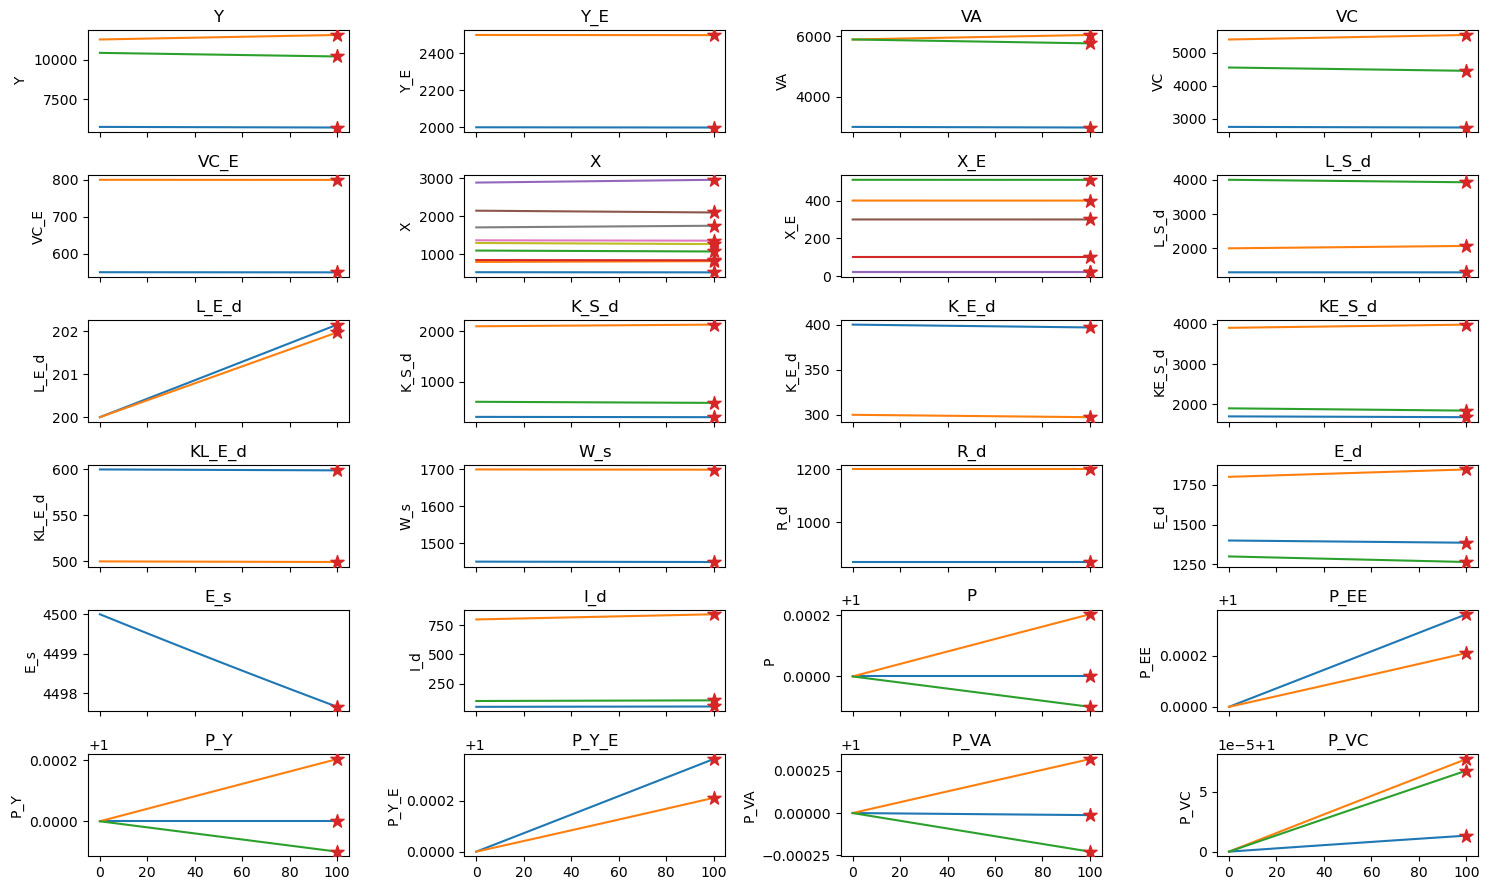

In [32]:
fig, ax = plt.subplots(6, 4, figsize=(15, 9), sharex=True)
for i, (axis, var) in enumerate(zip(fig.axes, mod.variable_names)):
    data = idata.variables[var]
    if data.ndim > 2:
        try:
            data = data.stack(pair=["i", "j"])
        except KeyError:
            data = data.stack(pair=["i", "k"])
    data.plot.line(x="step", ax=axis, add_legend=False)
    axis.set(title=var, xlabel=None)

    scatter_grid = np.full(int(np.prod(res_d[var].shape)), idata.variables.coords["step"].max())
    axis.scatter(scatter_grid, res_d[var].ravel(), marker="*", color="tab:red", zorder=10, s=100)
fig.tight_layout()

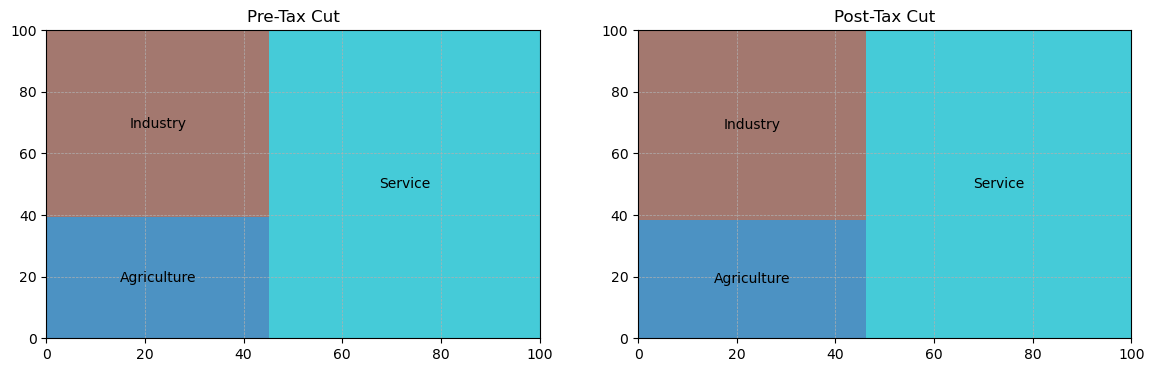

In [33]:
import squarify

fig, ax = plt.subplots(1, 2, figsize=(14, 4))
short_to_long = {"Ag": "Agriculture", "Ind": "Industry", "Serv": "Service"}

long_sectors = [short_to_long[x] for x in sectors]
cmap = plt.cm.tab10([0, 0.5, 1.0])

squarify.plot(sizes=calibrated_data["L_S_d"], label=long_sectors, alpha=0.8, ax=ax[0], color=cmap)
squarify.plot(sizes=res_d["L_S_d"], label=long_sectors, alpha=0.8, ax=ax[1], color=cmap)
for axis, title in zip(fig.axes, ["Pre-Tax Cut", "Post-Tax Cut"]):
    axis.grid(ls="--", lw=0.5)
    axis.set(title=title)